In [127]:
import numpy as np
import matplotlib.pyplot as plt
import tools

In [128]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Functions used:

In [214]:
def varBeta(regr, method, lmbd = 0):
    if method == 'ols':
        Bvar = np.sqrt(np.diag(regr.betaVar))
        return Bvar, regr.sigma_y
    if method == 'ridge':
        sigma = regr.sigma_y
        x = regr.symX
        W = np.linalg.inv(x+lmbd*np.eye(x.shape[0]))@x
        Bvar = np.sqrt(np.diag(sigma*W@np.linalg.inv(x)@W.T))
        
        return Bvar, sigma
    else:
        raise ValueError('method needs to be either "ols" or "ridge"')
    
def printvar(regr,Bvar,deg=5):
    mse = regr.squared_error()
    r2 = regr.r2score()
    print('MSE: ', mse)
    print('R2: ', r2)
    print('----- Conf. int.: -----')
    for i in range(len(Bvar)):
        if i in [0,5,10,15,20]:
            #print('B{:}: {:.4f} {} {:.4f}'.format(i,regr.beta[i],u'\xb1',Bvar[i]))
            #For latex
            print('$j={:}$ & {:.4f} {} {:.4f} \\'.format(i,regr.beta[i],'$\pm$',Bvar[i]))
        
    df = tools.get_exp_coeffs(beta=regr.beta,deg=deg, print_beta = False)
    plt.imshow(df)
    plt.colorbar()
    plt.xlabel('x order')
    plt.ylabel('y order')
    
    
    return mse,r2

In [224]:
def printvar_lasso(mse,r2,Bvar,reg, deg = 5):
    betas = np.zeros((len(Bvar),))
    print('MSE: ', mse)
    print('R2: ', r2)
    print('----- Conf. int.: -----')
    for i in range(len(Bvar)):
        beta = reg.coef_[i]
        betas[i] = beta
        #print('B{:}: {:f} {} {:f}'.format(i,beta,u'\xb1',Bvar[i]))
        if i in [0,5,10,15,20]:
            #For latex
            print('$j={:}$ & {:.4f} {} {:.4f} \\'.format(i,beta,'$\pm$',Bvar[i]))
        
    df = tools.get_exp_coeffs(beta=betas,deg=deg, print_beta = False)
    plt.imshow(df)
    plt.colorbar()
    plt.xlabel('x order')
    plt.ylabel('y order')

In [340]:
def print_scores_with_resmpl(X,z, lmbd=0, method = 'ols', smplsize=2000):
    if method.lower() not in ['ols','ridge','lasso']:
        raise ValueError('Invalid method flag, {}'.format(method))
    if method.lower() == 'ols' and lmbd != 0:
        raise ValueError('lmbd != 0 does not make sense for OLS.')
    if method.lower() == 'lasso':
        from sklearn.linear_model import Lasso 
    
    #mse=0
    #b_MSE_out = 0
    #b_R2_out = 0
    ## Without resampling
    if method.lower() == 'ols':
        regr = tools.Regression(X,z)
        zpred = regr.yhat
        mse = regr.squared_error()
        r2 = regr.r2score()
        out = tools.k_fold_val(x,y,z, method = 'ols', return_average=False,k=100)
        b_MSE_out, b_R2_out = tools.bootstrap(x,y,z, method = 'ols', r2_score=True, smplsize=smplsize)
    if method.lower() == 'ridge':
        regr = tools.Regression(X,z,lmbd = lmbd)
        zpred = regr.yhat
        mse = regr.squared_error()
        r2 = regr.r2score()
        out = tools.k_fold_val(x,y,z, method = 'ridge', lmbd=lmbd, return_average=False,k=100)
        b_MSE_out, b_R2_out = tools.bootstrap(x,y,z, lmbd=lmbd, method = 'ridge', r2_score=True, smplsize=smplsize)
    if method.lower() == 'lasso':
        reg = Lasso(alpha = lmbd, fit_intercept=False)
        reg.fit(X,z)
        zpred = reg.predict(X)
        mse = tools.squared_error(z,zpred)
        r2 = tools.r2score(z,zpred)
        out = tools.k_fold_val(x,y,z, method = 'lasso', lmbd=lmbd, return_average=False,k=100)
        b_MSE_out, b_R2_out = tools.bootstrap(x,y,z, lmbd=lmbd, method = 'lasso', r2_score=True, smplsize=smplsize)
    
    ## With k-fold
    k_R2_in = out.T[0]
    k_MSE_in = out.T[1]
    k_R2_out = out.T[2]
    k_MSE_out = out.T[3]   
        
# REGULAR PRINT, not for latex
#     print('--------- Without resampling ---------')
#     print('MSE: ', mse)
#     print('R2: ', r2)

#     print('------- With k-fold validation -------')
#     print('MSE (in): ', k_MSE_in)
#     print('R2 (in): ', k_R2_in)
#     print('MSE (out): ', k_MSE_out)
#     print('R2 (out): ', k_R2_out)

#     ## With bootstrap
#     print('----------- With bootstrap -----------')
#     print('MSE (out): ', np.average(b_MSE_out))
#     print('R2 (out): ', np.average(b_R2_out))

    # FOR latex
    print('MSE &',round(mse,4) ,\
          '&',round(np.average(k_MSE_out),4),'$\pm$',round(np.std(k_MSE_out),4),\
          '&', round(np.average(b_MSE_out),4),'$\pm$',round(np.std(b_MSE_out),4), '\\')
    print('R2 &',round(r2,4) ,\
          '&',round(np.average(k_R2_out),4),'$\pm$',round(np.std(k_R2_out),4),\
          '&', round(np.average(b_R2_out),4),'$\pm$',round(np.std(b_R2_out),4), '\\')

# Regression analysis
Performed on the data set is the franke function for x,y$\in$[0,1], defined below with additional variables used in the regression analysis

In [294]:
deg = 5 # degree of polynomial fit
N = 2000 # Data points
lambd = 0.01
noise = 0.1

x,y,z,noise = tools.generate_data(N=N, noise=noise)

X = tools.get_X_poly2D(x,y,deg=deg)

## Ordinary linear regression


Do regression and print MSE, R2 and beta with conf.int.

In [133]:
# X = tools.get_X_poly2D(x,y,deg=deg)

def olsBeta(X,z, errors = False):
    regr = tools.Regression(X,z,lmbd = 0)

    zpred = regr.yhat
    Bvar,sigma = varBeta(regr,method='ols')
    
    if errors == True:
        mse,r2 = printvar(regr,Bvar)
        
    return regr.beta,Bvar,sigma

### - Mean squared error and R2-score
MSE and R2 of ordinary linear regression, with and without k-fold and bootstrap

In [341]:
print_scores_with_resmpl(X,z, method = 'ols', smplsize=2000)

MSE & 0.0122 & 0.0125 $\pm$ 0.0037 & 0.0127 $\pm$ 0.0006 \
R2 & 0.8734 & 0.8532 $\pm$ 0.0606 & 0.8494 $\pm$ 0.01 \


In [135]:
## VAR PLoT
# plt.figure(figsize=(10,6))
# plt.subplot(2,2,1)
# plt.imshow(Bvar)
# plt.subplot(1,2,2)
# plt.errorbar(np.arange(len(Bvar)), regr.beta/regr.beta, yerr = np.sqrt(np.diag(Bvar)), fmt=".")
# plt.tight_layout()

In [136]:
# df = tools.get_exp_coeffs(Bvar)
# df.columns = ['x^{}'.format(i) for i in df.columns]
# df.index = ['y^{}'.format(i) for i in df.index]
# print(df.to_latex(na_rep='', escape = False,  column_format='lllllll'))

##### Beta coefficients and their confidence intervals

MSE:  0.01225614761676241
R2:  0.873356925108133
----- Conf. int.: -----
$j=0$ & 0.3092 $\pm$ 0.0494 \
$j=5$ & -33.9350 $\pm$ 2.2095 \
$j=10$ & 23.5317 $\pm$ 5.4283 \
$j=15$ & -14.6695 $\pm$ 2.1170 \
$j=20$ & -0.2200 $\pm$ 2.0670 \


(array([  0.30922325,   4.79421388,   8.07399502, -12.63430115,
        -17.1884009 , -33.93495674,  -1.10966407,  24.96849739,
         47.94068287,  45.69018631,  23.53171846, -34.54650237,
         -9.50902407, -56.98913001, -19.91011902, -14.66947795,
         18.49651852,  -4.5164772 ,  11.11673751,  20.42581552,
         -0.21995223]),
 array([0.04942561, 0.51815271, 0.47876823, 2.38758165, 1.93875674,
        2.20946192, 5.25710454, 3.99554821, 3.92358276, 4.96288202,
        5.42826611, 4.19915821, 4.01683704, 4.04862325, 5.22583925,
        2.11703987, 1.8762476 , 1.85108905, 1.84245167, 1.81208182,
        2.06699925]),
 0.01239246472877898)

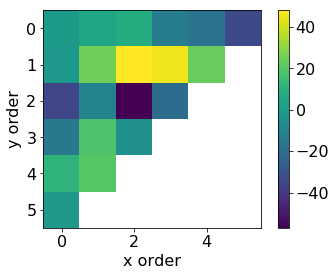

In [216]:
olsBeta(X,z, errors=True)

# Ridge regression

In [138]:
# X = tools.get_X_poly2D(x,y,deg=deg)
def ridgeBeta(X,z,lambd, errors = False):
    regr = tools.Regression(X,z,lmbd = lambd)
    
    zpred = regr.yhat
    Bvar,sigma = varBeta(regr,method = 'ridge', lmbd = lambd)

    if errors == True:
        mse,r2 = printvar(regr, Bvar)
    
    return regr.beta, Bvar, sigma
    

### - Mean squared error and R2-score
MSE and R2 of ridge regression, with and without k-fold and bootstrap

In [275]:
print_scores_with_resmpl(X,z, lmbd=0.00000005, method = 'ridge', smplsize=2000)

MSE & 0.0124 & 0.0131 & 0.0129 \
R2 & 0.8688 & 0.8614 & 0.845 \


##### Beta coefficients and their confidence intervals

MSE:  0.013433175640649131
R2:  0.8578197757260515
----- Conf. int.: -----
$j=0$ & 0.6889 $\pm$ 0.0283 \
$j=5$ & -13.8691 $\pm$ 0.5919 \
$j=10$ & 13.1950 $\pm$ 1.0550 \
$j=15$ & -8.3841 $\pm$ 0.5619 \
$j=20$ & -6.0760 $\pm$ 0.5510 \


(array([  0.68894853,   2.65677653,   3.06970482,  -9.07662932,
         -1.30613074, -13.8690776 ,   1.10493446,   1.79045722,
          9.617479  ,  12.19569699,  13.19495849, -10.64807866,
          6.25212745, -12.47222206,   3.95115576,  -8.38405508,
          8.52481774,  -7.87271352,   4.01039145,   2.50502345,
         -6.07604639]),
 array([0.0282606 , 0.19512141, 0.19848011, 0.58532342, 0.5268527 ,
        0.59191416, 0.91839054, 0.97494547, 0.98282125, 0.90836333,
        1.05496033, 1.30558771, 1.31379022, 1.2962644 , 1.02793713,
        0.5619366 , 0.86248188, 1.0422815 , 1.03969409, 0.85556991,
        0.55102843]),
 0.013582584065368181)

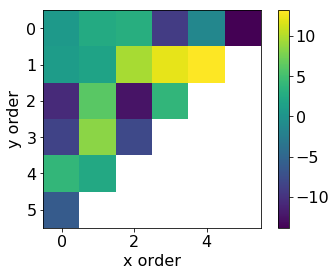

In [269]:
ridgeBeta(X,z, lambd=0.001, errors=True)

# Lasso regression

In [226]:
from sklearn.linear_model import Lasso

def lassoBeta(X,z,lambd, errors = False):
    reg = Lasso(alpha = lambd, fit_intercept=False)
    reg.fit(X,z)
    zpred = reg.predict(X)

    mse = tools.squared_error(z,zpred)
    r2 = tools.r2score(z,zpred)
    sigma = 1/(N-deg-1) * np.sum((z-zpred)**2)
    #Bvar = np.sqrt(np.diag(np.linalg.inv(X.T@X)*sigma))
    blist = tools.k_fold_val(x,y,z, statistic_func=beta_stat, return_average=False,method='lasso',lmbd=lambd, k=10)
    _,Bvar = beta_best(blist)
    if errors == True:
        printvar_lasso(mse,r2,Bvar,reg,deg)
        
    return reg.coef_, Bvar, sigma

### - Mean squared error and R2-score
MSE and R2 of lasso regression, with and without k-fold and bootstrap

In [268]:
print_scores_with_resmpl(X,z, lmbd=0.1, method = 'lasso', smplsize=2000)

MSE & 0.1045 & 0.1045 & 0.105 \
R2 & -0.1058 & -0.1065 & -inf \


/Users/heine2307/Documents/Universitet/UiO/FYS-STK4155/project1/tools.py:111: RuntimeWarning: divide by zero encountered in double_scalars
  return 1 - (np.sum((y-yhat)**2)/np.sum((y-ymean)**2))
/Users/heine2307/Documents/Universitet/UiO/FYS-STK4155/project1/tools.py:111: RuntimeWarning: divide by zero encountered in double_scalars
  return 1 - (np.sum((y-yhat)**2)/np.sum((y-ymean)**2))
/Users/heine2307/Documents/Universitet/UiO/FYS-STK4155/project1/tools.py:111: RuntimeWarning: divide by zero encountered in double_scalars
  return 1 - (np.sum((y-yhat)**2)/np.sum((y-ymean)**2))
/Users/heine2307/Documents/Universitet/UiO/FYS-STK4155/project1/tools.py:111: RuntimeWarning: divide by zero encountered in double_scalars
  return 1 - (np.sum((y-yhat)**2)/np.sum((y-ymean)**2))
/Users/heine2307/Documents/Universitet/UiO/FYS-STK4155/project1/tools.py:111: RuntimeWarning: divide by zero encountered in double_scalars
  return 1 - (np.sum((y-yhat)**2)/np.sum((y-ymean)**2))
/Users/heine2307/Document

##### Beta coefficients and their confidence intervals
Confidence intervals not correct, using formula for OLS 

MSE:  0.04019471074713284
R2:  0.5846670648414765
----- Conf. int.: -----
$j=0$ & 0.7004 $\pm$ 0.0062 \
$j=5$ & -0.2225 $\pm$ 0.0221 \
$j=10$ & -0.0000 $\pm$ 0.0000 \
$j=15$ & -0.0000 $\pm$ 0.0000 \
$j=20$ & -0.0000 $\pm$ 0.0000 \


(array([ 0.70042474, -0.        , -0.10303751, -0.52372367, -0.        ,
        -0.22249271, -0.        , -0.        , -0.        , -0.        ,
        -0.        , -0.        , -0.        , -0.        , -0.        ,
        -0.        , -0.        , -0.        , -0.        , -0.        ,
        -0.        ]),
 array([0.00621539, 0.        , 0.02049908, 0.00602781, 0.        ,
        0.02206085, 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        ]),
 0.040315657720293725)

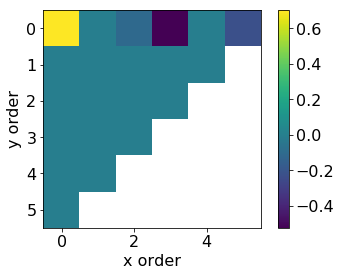

In [229]:
lassoBeta(X,z,lambd=lambd, errors=True)

# Plot beta as a function of lambda

/Users/heine2307/anaconda/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/Users/heine2307/anaconda/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/Users/heine2307/anaconda/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/Users/heine2307/anaconda/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objectiv

[-0.66889252 -0.72892939 -0.75027464 -0.80859463 -0.41037931 -0.30764133
 -0.         -0.          0.          0.        ]
[0.01893025 0.0190973  0.01966349 0.02151208 0.02579198 0.03554926
 0.05451485 0.10302665 0.17467312 0.27070966]


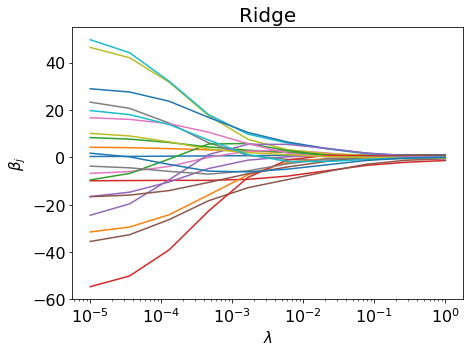

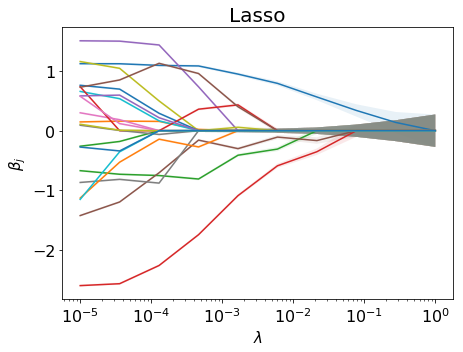

In [295]:
runs = 10
bnum = 10

# OLS beta is not dependent of lambda, so every point is the same
#Sb,Sv,Ss = olsBeta(X,z)
#Bnum = np.argsort(np.abs(Sb))
#bnum = Bnum[0]
#print('Bnum: ',bnum)
#Sbeta = np.ones(runs)*Sb[bnum]
#Svar = np.ones(runs)*Sv[bnum]
#Ssig = np.ones(runs)*Ss

#Rbeta = np.zeros(runs)
#Rvar = np.zeros(runs)
Rsig = np.zeros(runs)

Rlist = np.zeros((runs,X.shape[1]))

#Lbeta = np.zeros(runs)
#Lvar = np.zeros(runs)
#Lsig = np.zeros(runs)

Lsig = np.zeros((runs,X.shape[1]))
Llist = np.zeros((runs,X.shape[1]))

#x = 100*np.log10(np.arange(runs))
x_ = np.logspace(-5, 0, runs)
#x_ = np.linspace(0, 0.4, runs)

for i, lambd in enumerate(x_):
    Rb,Rv,Rs = ridgeBeta(X,z,lambd=lambd)
    #Rbeta[i] = Rb[bnum]
    #Rvar[i] = Rv[bnum]
    Rsig[i] = Rs
    Rlist[i][:] = Rb
    
    b = tools.k_fold_val(x,y,z, statistic_func=beta_stat, return_average=False,method='lasso',lmbd=lambd, k=10)
    _,Ls = beta_best(b)
    
    Lb,Lv,Ls = lassoBeta(X,z,lambd=lambd)
    #Lbeta[i] = Lb[bnum]
    #Lvar[i] = Lv[bnum]
    Lsig[i][:] = Ls
    Llist[i][:] = Lb

# #OLS
# plt.plot(x,Sbeta, 'r-')
# plt.fill_between(x,Sbeta+Ssig,Sbeta-Ssig,alpha=0.1,color='r')
# #Ridge
# plt.plot(x,Rbeta, 'b-')
# plt.fill_between(x,Rbeta+Rsig,Rbeta-Rsig,alpha=0.1,color='b')
# #Lasso
# plt.plot(x,Lbeta, 'g-')
# plt.fill_between(x,Lbeta+Lsig,Lbeta-Lsig,alpha=0.1,color='g')

plt.rcParams.update({'font.size': 16})
figridge = plt.figure(figsize=[7,5])
#plt.subplot(121)
for i in range(X.shape[1]):
    plt.semilogx(x_,Rlist.T[i])#,'b-')
    plt.fill_between(x_,Rlist.T[i]+Rsig,Rlist.T[i]-Rsig,alpha=0.1)#,color='b')
plt.xlabel(r'$ \lambda $',fontsize=15)
plt.ylabel(r'$ \beta_j $',fontsize=15)
plt.title('Ridge',fontsize=20)
#plt.legend(['B_{}'.format(i) for i in range(X.shape[1])])
plt.savefig('betaRidge.pdf')

print(Llist.T[2])
print(Lsig.T[2])

figlasso = plt.figure(figsize=[7,5])
for i in range(X.shape[1]):
    plt.semilogx(x_,Llist.T[i])#,'g-')
    plt.fill_between(x_,Llist.T[i]+Lsig.T[i],Llist.T[i]-Lsig.T[i],alpha=0.1)#,color='g')
plt.xlabel(r'$ \lambda $',fontsize=15)
plt.ylabel(r'$ \beta_j $',fontsize=15)
plt.title('Lasso',fontsize=20)
plt.savefig('betaLasso.pdf')

plt.show()

In [167]:
def beta_stat(regr,*args):
    return regr.coef_

def beta_best(betalist):
    n = betalist.shape[1]
    std = np.zeros(n)
    best = np.zeros(n)
    for i in range(n):
        betas = betalist.T[i]
        best[i] = np.mean(betas)
        std[i] = np.std(betas)
    return best,std

In [183]:
b = tools.k_fold_val(x,y,z, statistic_func=beta_stat, return_average=False,method='lasso',lmbd=lambd, k=10)
be,s = beta_best(b)
print(be)
print(s)

q,w,e = lassoBeta(X,z,lambd = lambd, errors=False)
print(q)


[ 0.70289787  0.         -0.18324824 -0.4939158   0.         -0.15255257
  0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.          0.        ]
[0.00695038 0.         0.02122864 0.00457467 0.         0.01844904
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.        ]
[ 0.7029158  -0.         -0.18328536 -0.49398098 -0.         -0.15250024
 -0.         -0.         -0.         -0.         -0.         -0.
 -0.         -0.         -0.         -0.         -0.         -0.
 -0.         -0.         -0.        ]
